In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [65]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','waterfront','view','lat','long'])
    ## removing duplicates
    df=df.drop_duplicates()
    ## add column total_sqft_building
    df['sqft_total'] = df['sqft_living'] + df['sqft_above']+df['sqft_basement']
    return df

In [66]:
re_df= load_original_data()
re_df=clean_data(re_df)

In [68]:
re_df.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'price',
       'sqft_total'],
      dtype='object')

### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [41]:
re_df[['bedrooms', 'bathrooms', 'floors','condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['bedrooms', 'bathrooms', 'floors','condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

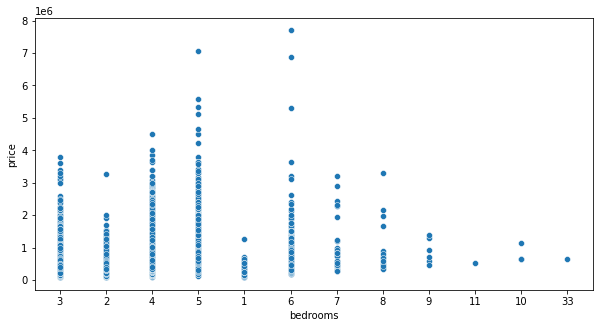

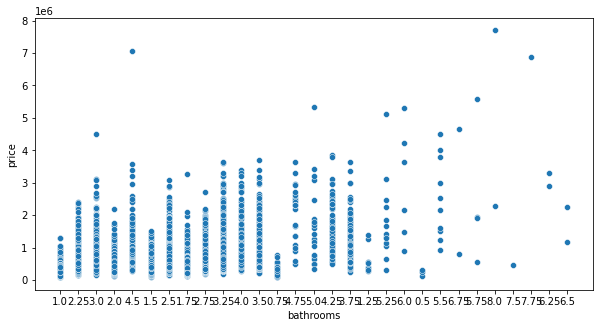

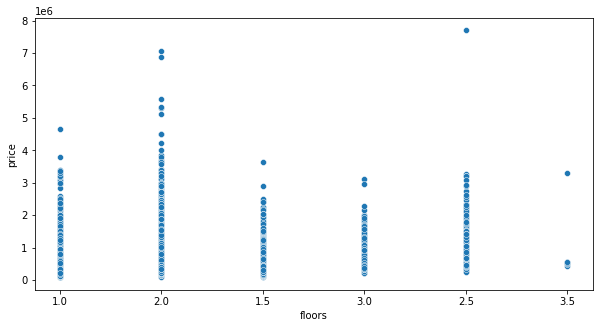

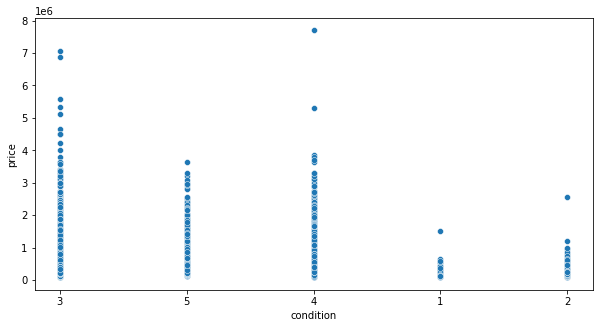

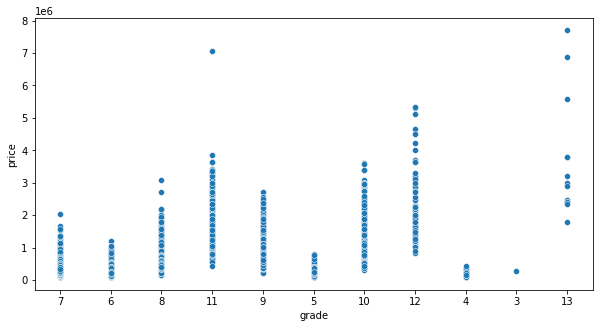

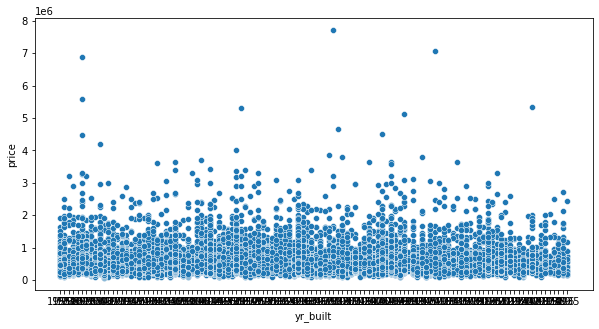

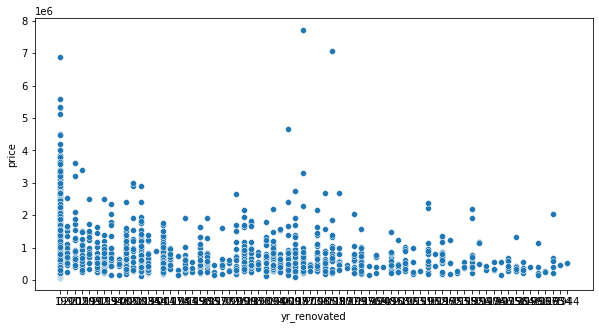

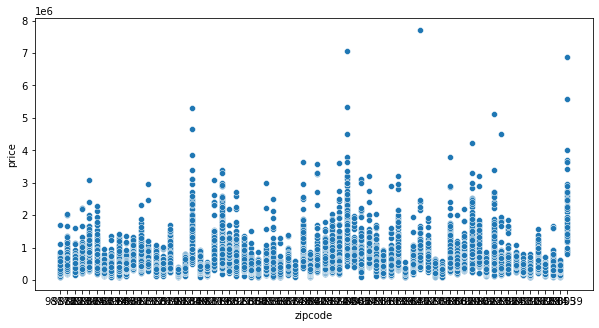

In [56]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

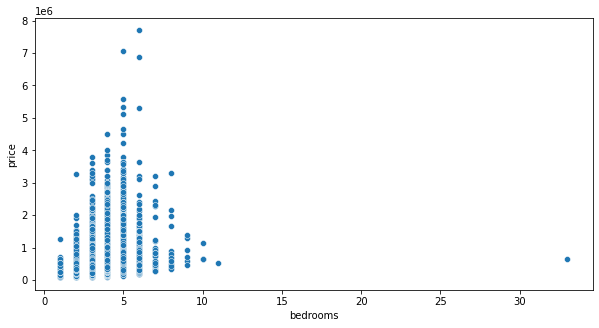

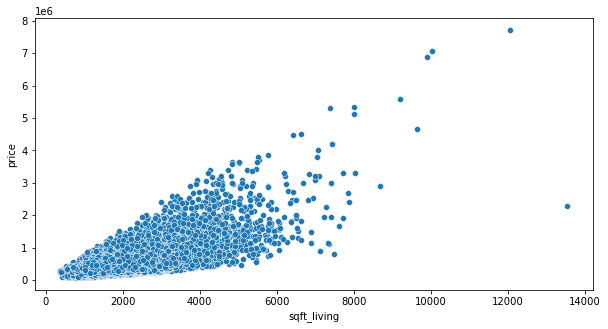

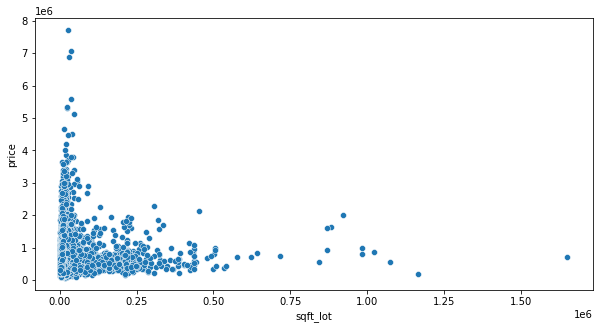

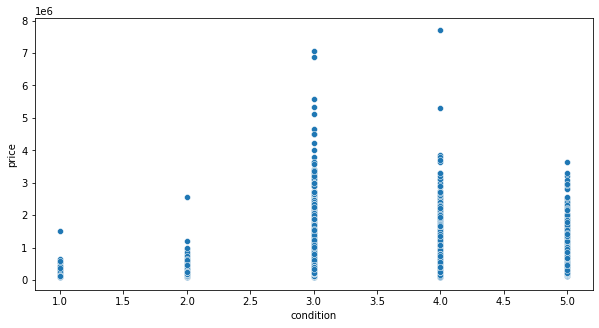

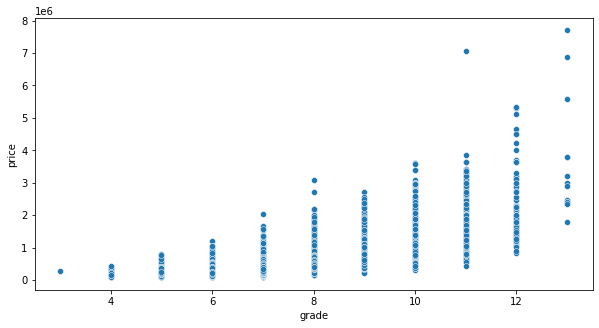

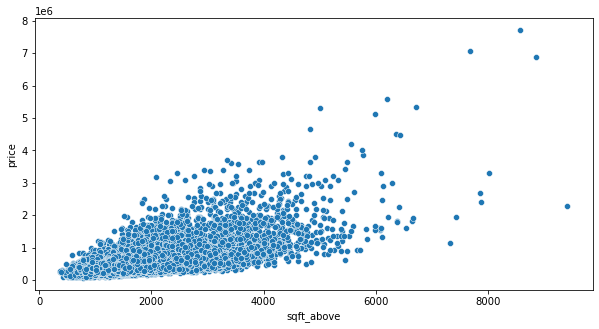

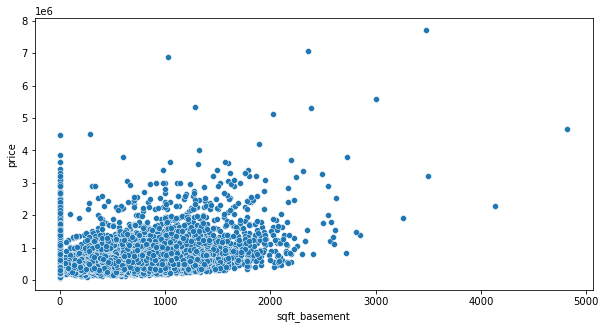

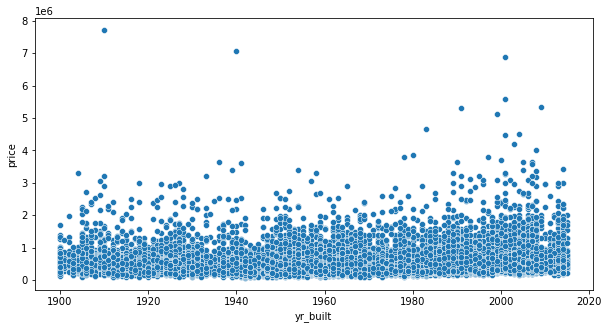

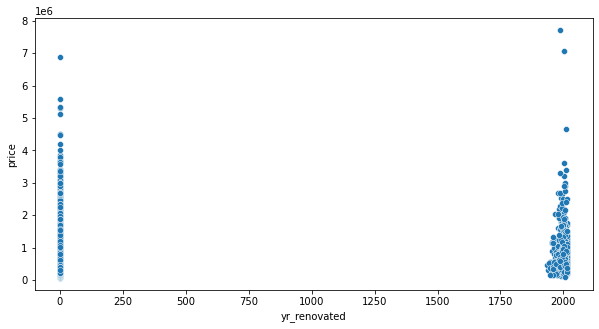

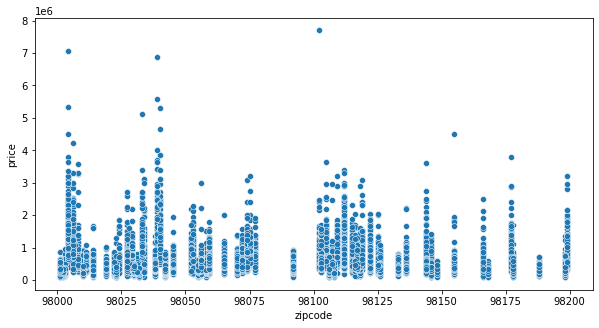

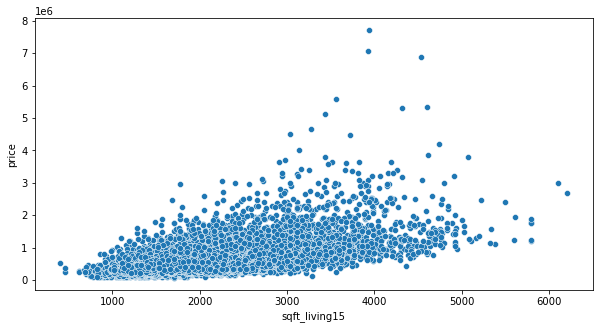

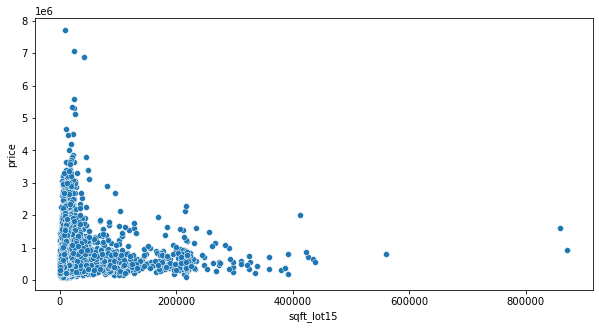

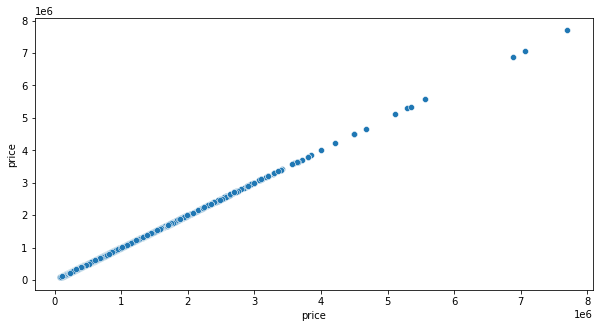

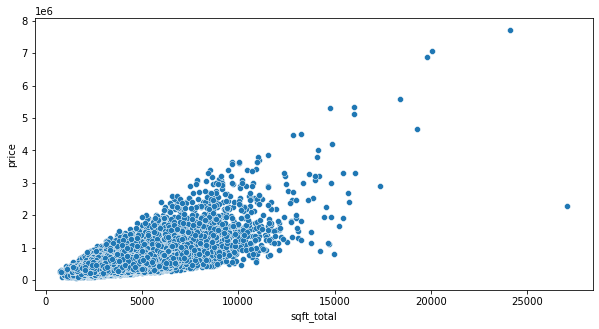

In [69]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

<AxesSubplot:xlabel='sqft_living'>

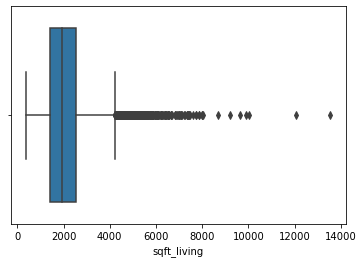

In [60]:
#removing outliers

# sqft_living
sns.boxplot(re_df.sqft_living)

In [62]:
Q1 = re_df.sqft_living.quantile(0.25)
Q3 = re_df.sqft_living.quantile(0.75)
IQR = Q3 - Q1

In [63]:
filter = (re_df["sqft_living"] >= Q1 - 1.5 * IQR) & (re_df["sqft_living"] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter] 

<AxesSubplot:>

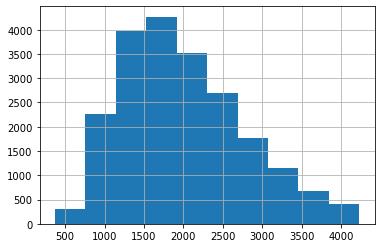

In [64]:
re_df.sqft_living.hist()

<AxesSubplot:xlabel='sqft_total'>

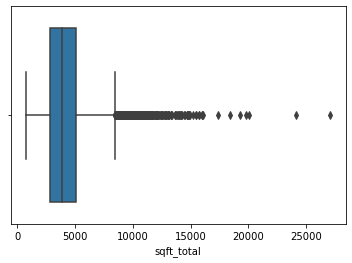

In [70]:
#removing outliers

# sqft_total
sns.boxplot(re_df.sqft_total)

In [71]:
Q1 = re_df.sqft_total.quantile(0.25)
Q3 = re_df.sqft_total.quantile(0.75)
IQR = Q3 - Q1

<AxesSubplot:>

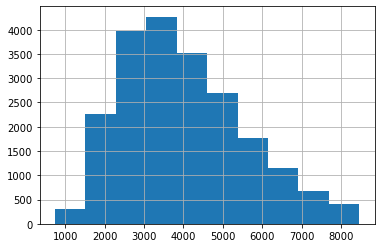

In [73]:
filter = (re_df["sqft_total"] >= Q1 - 1.5 * IQR) & (re_df["sqft_total"] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]
re_df.sqft_total.hist()